This notebook demonstrates the connection to a SQL database for extracting information about black markets in the darknet. The data were gathered for the article [Traveling the Silk Road](http://arxiv.org/abs/1207.7139) and can be accessed here: [CyLab](https://arima.cylab.cmu.edu/sr/). While most of the data processing is done after converting the tables to DataFrames, it would also be possible to directly use SQL statements via Python.

####importing necessary packages

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "dark", palette="Set2")
from sqlalchemy import create_engine
%matplotlib inline
%cd '/D/Dropbox/kasus/workspace'

/D/Dropbox/kasus/workspace


####loading user password and database name from a text file:

In [59]:
with open('mysqldata_2.txt', 'r') as f:
        lines = f.read().split('\n')
        pw = lines[0]
        db = lines[1]

#### connecting to database, listing all tables

In [61]:
engine = create_engine("mysql+mysqldb://root:" + pw + "@localhost/" + db + "?charset=utf8&use_unicode=0")
conn = engine.connect()
conn.execute('''SHOW TABLES''').fetchall()

[('feedback',), ('item',), ('price',)]

### Items

Description:


An <i>item</i> table which contains all items processed. This table has the following fields:
<ul>
        <li>
        <i>item_id</i>: A <i>varchar(10)</i> field containing a hash of the corresponding Silk Road item handle. Note that this field is <b>not</b> the actual Silk Road item handle, but a hashed version of it. <b>You cannot directly map these handles with item handles currently used on the site.</b>
        </li>
        <li>
        <i>seller</i>: A <i>varchar(10)</i> field containing a hash of 
        the corresponding Silk Road seller handle advertising the item. Note that this field is <b>not</b> the actual Silk Road seller handle, but a hashed version of it. <b>You cannot directly map these handles with seller handles currently in use on the site. </b>
        </li>
        <li>
        <i>ships_to</i>: A <i>varchar(50)</i> field containing the advertised acceptable shipping destinations for the item.
        </li>
        <li>
        <i>ships_from</i>: A <i>varchar(50)</i> field containing the advertised origin of the item.
        <li>
        <i>category</i>: An unsigned integer denoting the item category. A mapping between <i>category</i> and actual category names can be found in <a href="data/categories.csv">this CSV file</a>.
        </li>
        <li>
        <i>first_seen</i>: An unsigned integer representing the first time the crawler found the item on the site. This is expressed in UNIX epoch time. Note that <i>first_seen</i> is bound by the beginning of the measurement interval. 
        </li>
        <li>
        <i>last_seen</i> An unsigned integer representing the last time the crawler found the item on the site. This is expressed in UNIX epoch time. Note that <i>last_seen</i> is bound by the end of the measurement interval. 
        </li>
        </ul>
        </li>


In [27]:
item = pd.read_sql('item', engine)
len(item)

24385

In [28]:
item.head(3)

,item_id,name,seller,ships_to,ships_from,category,description,first_seen,last_seen
0,fdb3183653,Social Engineering: The Art of Human Hacking,d6a92adda4,Worldwide,undeclared,122,Description:,1328245275,1343111718
1,849b238ab7,Big Brother and the Company Hackers,d6a92adda4,Worldwide,undeclared,122,Description:<br />,1328242190,1343120230
2,788799659c,BSD Rootkits: An Introduction to Kernel Hacking,d6a92adda4,Worldwide,undeclared,122,Description:<br />,1328242190,1343111924


#### define function for the conversion of unix epoch time

In [9]:
import time
def convert_time(string):
    date = time.strftime('%m-%d-%Y', time.localtime(string))
    return date

In [30]:
item.first_seen = item.first_seen.apply(convert_time)
item.last_seen = item.last_seen.apply(convert_time)

In [31]:
item.head(3)

,item_id,name,seller,ships_to,ships_from,category,description,first_seen,last_seen
0,fdb3183653,Social Engineering: The Art of Human Hacking,d6a92adda4,Worldwide,undeclared,122,Description:,02-03-2012,07-24-2012
1,849b238ab7,Big Brother and the Company Hackers,d6a92adda4,Worldwide,undeclared,122,Description:<br />,02-03-2012,07-24-2012
2,788799659c,BSD Rootkits: An Introduction to Kernel Hacking,d6a92adda4,Worldwide,undeclared,122,Description:<br />,02-03-2012,07-24-2012


#### converting category ID's

In [32]:
cats = pd.read_csv('categories.csv', names = ['ids', 'categories'])
cats.head(3)

,ids,categories
0,"171, 186",Blotter
1,"204, 232",6-APB
2,"211, 260",Toys


In [33]:
dic = {}
for row in cats.iterrows():
    entries = row[1][0].split(',')
    for entry in entries:
        entry = entry.strip(" ")
        if entry not in dic:
            dic[entry] = row[1][1]

In [34]:
def cat_mapper(x):
    try: 
        x = dic[str(x)]
    except KeyError:
        x = None
    return x

In [35]:
item.category = item.category.apply(cat_mapper)
item.head()

,item_id,name,seller,ships_to,ships_from,category,description,first_seen,last_seen
0,fdb3183653,Social Engineering: The Art of Human Hacking,d6a92adda4,Worldwide,undeclared,Books,Description:,02-03-2012,07-24-2012
1,849b238ab7,Big Brother and the Company Hackers,d6a92adda4,Worldwide,undeclared,Books,Description:<br />,02-03-2012,07-24-2012
2,788799659c,BSD Rootkits: An Introduction to Kernel Hacking,d6a92adda4,Worldwide,undeclared,Books,Description:<br />,02-03-2012,07-24-2012
3,272924f991,Metamizole 2 x 500mg - Analgesic and Antipyretic,7089b83448,Worldwide,Canada,Drugs,"Good day SR,",02-03-2012,03-06-2012
4,06e58c7c73,Celebrex 200mg x 20 - Pain Reliever,7089b83448,Worldwide,Canada,Prescription,"Hey SR,",02-03-2012,03-06-2012


####plotting the ten most common categories

In [36]:
order = list(item['category'].value_counts()[:10].index)
item10 = item[item['category'].isin(order)]

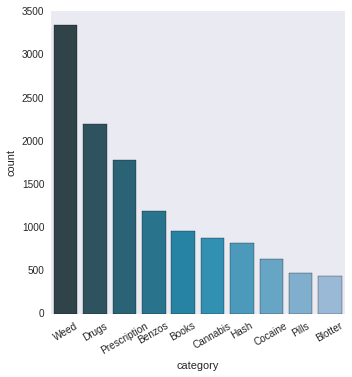

In [37]:
plot = sns.factorplot('category', data=item10, x_order=order, palette="PuBuGn_d")
plot.set_xticklabels(rotation=30)

#### Exporting Items

In [38]:
item.to_csv('silkroad_items.csv')

 ``` The .csv-file``` can be downloaded [here](!https://www.dropbox.com/s/3g5mt2dvxl9lgki/silkroad_items.csv?dl=1) . [Download is deactivated at the moment since the files contains sensible information.

## Feedback

Description:


A <i>feedback</i> table which contains feedback on all items processed. This table has the following fields:
<ul>
        <li>
        <i>item_id</i>: A <i>varchar(10)</i> field containing a hash of the corresponding Silk Road item handle. This corresponds to the handle in the <i>item</i> table. 
        </li>
        <li>
        <i>feedback_time</i>: An unsigned integer representing (an approximate value of) the time, in UNIX epoch time, at which the feedback was deposited.</li>
        <li> 
        <i>feedback_rating</i>: A <i>smallint</i> representing the feedback rating that was given.
        </li>
        <li>
        <i>feedback_hash</i>: A <i>varchar(32)</i> representing a hash of the text entered as feedback.
        </li>
</ul>


In [39]:
feedback = pd.read_sql('feedback', engine)
len(feedback)

184804

In [40]:
feedback.feedback_time = feedback.feedback_time.apply(convert_time)

In [41]:
feedback.head()

,item_id,feedback_time,feedback_rating,feedback_text,feedback_hash
0,fdb3183653,11-05-2011,5,Everything is a-ok,512956b3447f053febb5736e38702013
1,fdb3183653,02-03-2012,5,Received link in seconds. Thanks warbot!,6987bad465d9df6e77f1a4be5442b786
2,fdb3183653,01-15-2012,5,GREAT! Super Fast!,209f5182885e4dfd2cef8279d902e370
3,fdb3183653,01-15-2012,5,awesome a+++++++++++,0cfddc2ae20512d506ddc4c50a50f226
4,fdb3183653,01-13-2012,5,Super Quick Delivery!,f8924a31f7f62430430dcc6270809792


#### Exporting Feedbacks:

In [42]:
feedback.to_csv('silkroad_feedback.csv')

The ```.csv-Datei``` can be downloaded [here](https://www.dropbox.com/s/a1x37z6lofs04fm/silkroad_feedback.csv?dl=1).

### Price

Description:

 A <i>price</i> table containing the price of the items, with the following fields:
        
<ul>
        <li>
        <i>item_id</i>: A <i>varchar(10)</i> field containing a hash of the corresponding Silk Road item handle. This corresponds to the handle in the <i>item</i> (and <i>feedback</i>) table(s). 
        </li>
        <li>
        <i>price</i>: A <i>decimal(10,2) unsigned</i> representing the price in Bitcoin of the item as advertised at the time of parsing.
        </li>
        <li>
        <i>time</i>: An unsigned integer representing the time (in UNIX epoch time) at which the price for that item was recorded.
        </li>
</ul>


In [62]:
price = pd.read_sql('price', engine)
len(price)

799312

In [7]:
price.head()

,item_id,price,time
0,fdb3183653,0.10,1328245275
1,fdb3183653,0.10,1328247767
2,849b238ab7,0.10,1328242190
3,788799659c,0.16,1328242190
4,272924f991,1.41,1328241659


In [ ]:
price.time = price.time.apply(convert_time) # Error due to size ==> iterative approach

In [47]:
price.time.fillna('nan', inplace=True)

In [50]:
from IPython.display import clear_output
for i in price.index[703977:]:
    print i, price.ix[i, 'time']
    if price.ix[i, 'time'] != 'nan':
        price.ix[i, 'time'] = convert_time(price.ix[i, 'time'])
        print i, price.ix[i, 'time']
    clear_output(wait=True)

799311 1343099444.0
799311 07-24-2012


In [51]:
price.head()

,item_id,price,time
0,fdb3183653,0.10,02-03-2012
1,fdb3183653,0.10,02-03-2012
2,849b238ab7,0.10,02-03-2012
3,788799659c,0.16,02-03-2012
4,272924f991,1.41,02-03-2012


#### Exporting Price

In [52]:
price.to_csv('silkroad_price.csv')

The ```.csv-file``` can be downloaded [here](https://www.dropbox.com/s/xbuk3j3zxzeadwe/silkroad_price.csv?dl=1).

## Analysis

work in progress